<h1>Objetivo principal</h1>
Crear un clasificador de correos de spam utilizando varias técnicas de aprendizaje Machine Learning, para realizar nuestro objetivo realizaremos varias tareas (carga y análisis de datos, comparación entre diferentes alternativas existentes, comparar mejor alternativa existente con Machine Learning de redes neuronales).
<h2>Librerias importadas</h2>
En este apartado se algunas de las librerias importadas.

<code>warnings</code>:Libreria util para controlar las excepciones, al obtener el valor action='ignore' 	
nunca imprima advertencias

Referencia: https://docs.python.org/3/library/warnings.html

<code>optparse</code>:Analiza las opciones de la línea de comandos, utiliza un estilo más declarativo de análisis de línea de comandos: crea una instancia de OptionParser, la rellena con opciones y analiza la línea de comandos, permite a los usuarios especificar opciones en la sintaxis GNU/POSIX convencional y, además, genera mensajes de uso y ayuda para usted.

Referencia: https://docs.python.org/3/library/optparse.html

<code>matplotlib.pyplot</code>:Interfaz basada en estado para matplotlib. Proporciona una forma de representación gráfica implícita, similar a MATLAB. También abre figuras en su pantalla y actúa como el administrador de GUI de figuras.

Referencia: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html



In [1]:
# Manejo de datos
#Leer CSV
import pandas as pd
import numpy as np
from optparse import OptionParser
import sys
from time import time
# Para procesar los datos 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

#nltk.download('punkt')
#nltk.download('stopwords')
# Visualizacion
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn.utils.extmath import density
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

# DL
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

#Metricas de precision
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ignorar advertencias 
import warnings
warnings.filterwarnings(action='ignore')


# Optimizar comandos de linea 
op = OptionParser()

<h1>Lectura de datos</h1>


<code>read_csv</code>:Lea un archivo de valores separados por comas (formato csv) en un marco de datos, También admite, opcionalmente, dividir el archivo en fragmentos.  
Referencia: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

<code>drop</code>:Elimina filas o columnas especificando nombres de etiquetas y ejes correspondientes, o especificando directamente nombres de índices o columnas. Cuando se utiliza un índice múltiple, las etiquetas en diferentes niveles se pueden eliminar especificando el nivel. 

Referencia: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html


In [2]:
#Archivo de lectura 
df = pd.read_csv('Dataset/spam_ham_dataset.csv')
# Quitamos columnas innecesarias 
df.drop('Unnamed: 0', axis=1, inplace = True)
# Cambiamos el nombre de las columnas 
df.columns = ['etiqueta', 'texto', 'clase']

<h1>Cabecera</h1>

<code>head</code>:Esta función devuelve las primeras n filas del objeto según la posición. Es útil para probar rápidamente si su objeto tiene el tipo correcto de datos.

Referencia: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html



In [3]:
#Mostramos cabecera con los datos de los 1o primeros registros 
df.head(10)


,etiqueta,texto,clase
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,ham,Subject: ehronline web address change\r\nthis ...,0
6,ham,Subject: spring savings certificate - take 30 ...,0
7,spam,Subject: looking for medication ? we ` re the ...,1
8,ham,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


<h1>Total registros en CSV</h1>

In [4]:
print(f'El dataset tiene un total de {df.shape[0]} E-Mails, pueden categorizarse en ham y spam')

El dataset tiene un total de 5171 E-Mails, pueden categorizarse en ham y spam


<h1>Grafico registros HAM SPAM</h1>

<code>figure</code>:Crea una nueva figura o active una figura existente. El parámetro 'figsize' determina ancho y alto en pulgadas

Referencia: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html

<code>set_theme</code>:Establece aspectos del tema visual para todas las tramas matplotlib y seaborn. Esta función cambia los valores predeterminados globales para todos los gráficos

Referencia: https://seaborn.pydata.org/generated/seaborn.set_theme.html

<code>countplot</code>:Muestre los conteos de observaciones en cada contenedor categórico usando barras. Un gráfico de conteo se puede considerar como un histograma a través de una variable categórica, en lugar de cuantitativa. Los datos de entrada se pueden pasar en una variedad de formatos, que incluyen vectores de datos representados como listas, matrices numpy u objetos pandas, marcos de datos en "formato largo" y "formato ancho" y matrices de vectores.

Referencia: https://seaborn.pydata.org/generated/seaborn.countplot.html

<AxesSubplot:xlabel='etiqueta', ylabel='count'>

<Figure size 864x432 with 0 Axes>

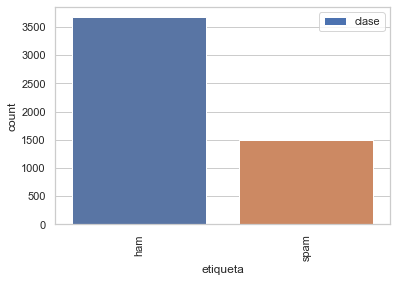

In [5]:
#Cargamos un gráfico con el numero de registros spam y ham
plt.figure(figsize = (12, 6))
#Establece estilo del aspecto visual 
sns.set_theme(style="whitegrid")
df.plot(kind="bar")
# Muestre los conteos de observaciones en cada contenedor categórico usando barras. 
sns.countplot(data = df, x = 'etiqueta')

<h1>Tokenizadores de expresiones regulares</h1>

<code>RegexpTokenizer</code>Divide una cadena en subcadenas usando una expresión regular.

Referencia: https://www.nltk.org/_modules/nltk/tokenize/regexp.html


In [6]:
from nltk.tokenize import RegexpTokenizer

def clean_str(string, reg = RegexpTokenizer(r'[a-z]+')):
#Limpiamos el texto con RegexpTokenizer y pasamos a minusculas 
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)

<h1>Limpieza de datos </h1>

<code>stopwords</code>:Lectores de corpus NLTK. Los módulos de este paquete proporcionan funciones que se pueden usar para leer archivos de corpus en una variedad de formatos. Estas funciones se pueden usar para leer tanto los archivos de corpus que se distribuyen en el paquete de corpus NLTK como los archivos de corpus que forman parte de corpus externos.

Referencia: https://www.nltk.org/api/nltk.corpus.html


In [7]:
#limpiamos los datos
#Referencia 
stop_words = set(stopwords.words('english')) 

df['texto'] = df['texto'].apply(lambda x: ' '.join([ word for word in word_tokenize(x)  if not word in stop_words]))
df['texto'] = df['texto'].apply(lambda string: clean_str(string))
#Mostramos los datos en limpio
df.head()


,etiqueta,texto,clase
0,ham,subject enron methanol meter follow note gave ...,0
1,ham,subject hpl nom january see attached file hpln...,0
2,ham,subject neon retreat ho ho ho around wonderful...,0
3,spam,subject photoshop windows office cheap main tr...,1
4,ham,subject indian springs deal book teco pvr reve...,0


<h1>Matriz de recuento de tokens</h1>

<code>CountVectorizer</code>
:Convierta una colección de documentos de texto en una matriz de recuentos de tokens. Esta implementación produce una representación escasa de los recuentos mediante scipy.sparse.csr_matrix. Si no proporciona un diccionario a priori y no utiliza un analizador que realice algún tipo de selección de características, entonces la cantidad de características será igual al tamaño del vocabulario encontrado al analizar los datos.

Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

<code>fit_transform</code> :Aprenda el diccionario de vocabulario y devuelva la matriz documento-término. Esto es equivalente a ajuste seguido de transformación, pero implementado de manera más eficiente.

Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform

In [8]:
# Convertir una colección de documentos de texto en una matriz de recuentos de tokens
# 
from sklearn.feature_extraction.text import CountVectorizer
vectorizador = CountVectorizer()
#Transformamos los datos de texto
X = vectorizador.fit_transform(df.texto)

y = df.etiqueta



<h1>División subconjuntos de prueba y entrenamiento</h1>

<h2>train_test_split</h2>
:Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba. Utilidad rápida que envuelve la validación de entrada y la aplicación para ingresar datos en una sola llamada para dividir (y opcionalmente submuestrear) datos en una sola línea.
En este apartado se determinan las parámetros generales que se han utilizado.

<code>test_size</code>    :Representa el número absoluto de muestras de prueba.

<code>random_state</code>
:Controla la mezcla aplicada a los datos antes de aplicar la división. Pase un int para una salida reproducible en múltiples llamadas a funciones.   
<code>shuffle</code>
:Si mezclar o no los datos antes de dividirlos.
     
Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:
#Dividir arreglos o matrices en subconjuntos de prueba y entrenamiento aleatorio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle = True)


<h1>Número de registros y tokens </h1>


In [10]:
print(f"NÚMERO DE OBSERVACIONES: {X.shape[0]}\nTOKENS: {X.shape[1]}")


NÚMERO DE OBSERVACIONES: 5171
TOKENS: 45595


<h1>Rendimiento modelos</h1>
Entrenamos y probamos los conjuntos de datos con los diferentes modelos de clasificación y obtenemos resultados de rendimiento para cada modelo.

Referencia: https://scikit-learn.org/0.22/auto_examples/text/plot_document_classification_20newsgroups.html


In [11]:
# https://scikit-learn.org

def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
def benchmark(clf):
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0

    score = metrics.accuracy_score(y_test, pred)
    print("Entrenando: ",clf,"Tiempo de entrenamiento",train_time,"Exactitud",score)
   
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time
results = []
#Entrenando modelos Ridge Classifier, Perceptron, Passive-Aggressive, kNN, Random forest
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    # entrenando Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # entrenando SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# entrenando SGD con Elastic Net penalty
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# entrenando  without threshold
results.append(benchmark(NearestCentroid()))

#Algoritmos basados en Naive Bayes
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))


results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))



Entrenando:  RidgeClassifier(solver='sag', tol=0.01) Tiempo de entrenamiento 0.23855066299438477 Exactitud 0.8154589371980676

Entrenando:  Perceptron(max_iter=50) Tiempo de entrenamiento 0.015621662139892578 Exactitud 0.9739130434782609

Entrenando:  PassiveAggressiveClassifier(max_iter=50) Tiempo de entrenamiento 0.01558828353881836 Exactitud 0.9681159420289855

Entrenando:  KNeighborsClassifier(n_neighbors=10) Tiempo de entrenamiento 0.015620946884155273 Exactitud 0.7971014492753623

Entrenando:  RandomForestClassifier() Tiempo de entrenamiento 11.031389474868774 Exactitud 0.9768115942028985

Entrenando:  LinearSVC(dual=False, tol=0.001) Tiempo de entrenamiento 0.06245231628417969 Exactitud 0.970048309178744

Entrenando:  SGDClassifier(max_iter=50) Tiempo de entrenamiento 0.015621423721313477 Exactitud 0.9797101449275363

Entrenando:  LinearSVC(dual=False, penalty='l1', tol=0.001) Tiempo de entrenamiento 0.175520658493042 Exactitud 0.9642512077294686

Entrenando:  SGDClassifier(max_

<h1>Gráfica rendimiento</h1>
Creamos grafica de rendimiento con las velocidades de entrenamiento, prueba y exactitud.

Referencia: https://scikit-learn.org/0.22/auto_examples/text/plot_document_classification_20newsgroups.html


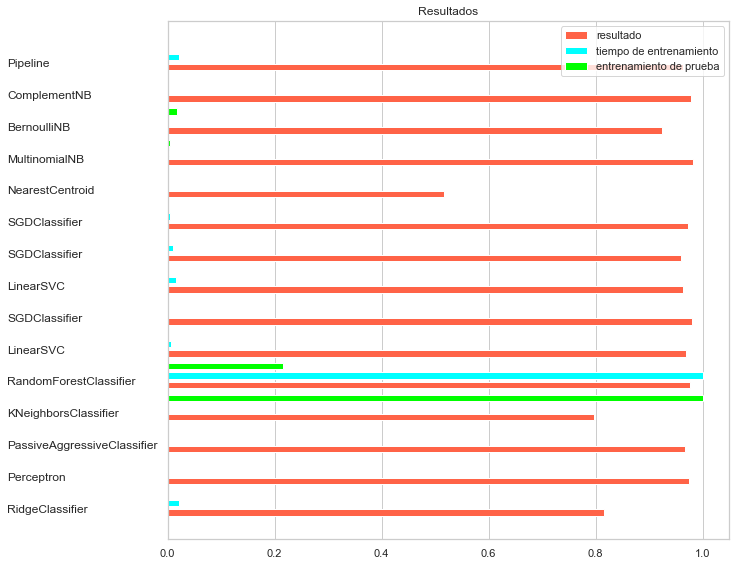

In [12]:
#Crear grafico con los resultados

indices = np.arange(len(results))
results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)
#Definir tamaño
plt.figure(figsize=(12, 8))
#Definir titulos y colores
plt.title("Resultados")
plt.barh(indices, score, .2, label="resultado", color='tomato')
plt.barh(indices + .3, training_time, .2, label="tiempo de entrenamiento",
         color='aqua')
plt.barh(indices + .6, test_time, .2, label="entrenamiento de prueba", color='lime')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

<h1>Obtener mejores hiperparámetros</h1>

<code>RandomizedSearchCV</code>
:Búsqueda aleatoria en hiperparámetros.Los parámetros del estimador que se utilizan para aplicar estos métodos se optimizan mediante una búsqueda de validación cruzada sobre la configuración de los parámetros.

A diferencia de GridSearchCV, no se prueban todos los valores de los parámetros, sino que se muestrea un número fijo de configuraciones de parámetros de las distribuciones especificadas.

Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html


In [13]:
# Busca el mejor hiperparametros con RandomizedSearchCV
from sklearn.naive_bayes import ComplementNB
# Buscamos con los parámetros mostrados para obtener el mejor resultado
from sklearn.model_selection import RandomizedSearchCV
parametros = {"alpha": [0.1,0.2,0.3,1,2,5,10], "fit_prior": [True, False],"norm": [True, False]}

rds = RandomizedSearchCV(ComplementNB(), parametros,refit = True,random_state=0)
rds.fit(X_train,y_train)

print("Mejores hiperparametros :",rds.best_params_)
print("Exactitud :",rds.best_score_)



Mejores hiperparametros : {'norm': False, 'fit_prior': True, 'alpha': 0.2}
Exactitud : 0.9792074841257323


<h1>Creación modelo</h1>
<h2>ComplementNB</h2>

El clasificador Complement Naive Bayes fue diseñado para corregir las "suposiciones severas" hechas por el clasificador Multinomial Naive Bayes estándar. Es especialmente adecuado para conjuntos de datos desequilibrados. Los parámetros que acepta son:

<code>alpha</code>:Parámetro de suavizado aditivo. Predeterminado = 1.0

<code>fit_prior</code>:Solo se usa en caso de borde con una sola clase en el conjunto de entrenamiento. Por defecto=True

<code>norm</code>:Si se realiza o no una segunda normalización de los pesos. El comportamiento predeterminado refleja las implementaciones encontradas en Mahout y Weka. Por defecto=false

Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html


In [14]:
# Crea un modelo con hiperparametros
from sklearn.naive_bayes import ComplementNB
alpha, fit_prior = rds.best_params_['alpha'], rds.best_params_['fit_prior']
model = ComplementNB(alpha = alpha, fit_prior=fit_prior, norm=False)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)



<h1>Exactitud del modelo</h1>
Mostramos la exactitud obtenido por este modelo para el conjunto de datos, en este caso con una predicción de 97,89%.

In [15]:
#Mostramos predicción
from sklearn.metrics import classification_report, accuracy_score
exactitud_predefinido = round(accuracy_score(y_test,y_pred),3)*100
print(f'# Exactitud: {exactitud_predefinido}%\n')

# Exactitud: 97.89999999999999%



<h1>Matriz de confusión</h1>
Permite ver de manera visual el desempeño del modelo.

<code>confusion_matrix</code>
Calcula la matriz de confusión para evaluar la precisión de una clasificación.

Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

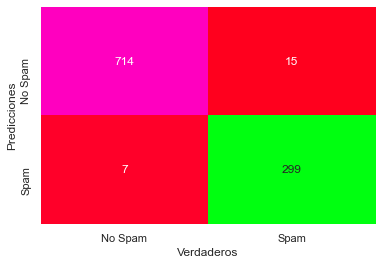

In [16]:
#Creamos matriz de confusion 
cmat = confusion_matrix(y_test, y_pred)
grafica=sns.heatmap(cmat, annot = True, cmap = 'gist_rainbow', cbar = False, fmt="d", xticklabels=['No Spam', 'Spam'], yticklabels=['No Spam', 'Spam'])

grafica.set(xlabel='Verdaderos', ylabel='Predicciones')
plt.show()

<h1>Creación modelo red neuronal</h1>

<h2>Sequential</h2>
Este tipo de modelo es una pila de capas donde cada capa tiene un tensor de entrada y uno de salida, este modelo es util cuando solo hay una entrada y una salida, en nuestro caso en la capa de salida solo puede ser spam o ham

Referencia: https://keras.io/guides/sequential_model/

<h2>Capas(layers)</h2>
Las capas son el componente fundamental de los modelos basados en redes neuronales, cada capa consta de una función de cálculo de tensor de entrada y tensor de salida  y algún estado, contenido en las variables de TensorFlow (los pesos de la capa ).

Referencia: https://keras.io/api/layers/

Para poder agregar capas usaremos la instrucción add.

<code>add</code>
:Agrega una lista de entradas, toma como entrada una lista de tensores, todos de la misma forma, y devuelve un solo tensor.

Referencia: https://keras.io/api/layers/merging_layers/add/

In [17]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense

#Creamos modelo red neuronal
#Capa visible 1 entrada
input_dim = 1
model_red = Sequential()
#2 capas ocultas
model_red.add(layers.Dense(16, input_dim=input_dim, activation='relu'))
model_red.add(Dense(8, activation='relu'))
#Una capa de salida
model_red.add(layers.Dense(1, activation='sigmoid'))


<h1>Optimizador y perdida</h1>

<code>Perdida(loss)</code>
:El propósito de las funciones de pérdida es calcular la cantidad que un modelo debería tratar de minimizar durante el entrenamiento. Hemos elegido 'BinaryCrossentropy' ya que calcula la pérdida de entropía cruzada entre etiquetas verdaderas y etiquetas predichas, utiliza esta pérdida de entropía cruzada para aplicaciones de clasificación binaria.

Referencia: https://keras.io/api/losses/

<code>Optimizador(optimizer)</code>
:Un optimizador es uno de los dos argumentos necesarios para compilar un modelo de Keras, hemos elegido 'adamax' que implementa el algoritmo 'Adamax' que esta basada en la norma del infinito. 

Referencia: https://keras.io/api/optimizers/adamax/

<code>Metrica(metrics)</code>
:Una métrica es una función que se utiliza para juzgar el rendimiento de su modelo. Las funciones métricas son similares a las funciones de pérdida, excepto que los resultados de la evaluación de una métrica no se utilizan al entrenar el modelo. Hemos elegido 'accuracy' ya que calcula la frecuencia con la que las predicciones que equivalen a etiquetas.

Referencia: https://keras.io/api/optimizers/adamax/

In [18]:
#Añadimos optimizador y perdida al modelo

model_red.compile(loss='binary_crossentropy', 
              optimizer='adamax', 
              metrics=['accuracy'])
model_red.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


<h1>Tranformación del texto para modelo de redes neuronales</h1>

<code>LabelEncoder</code>
:Codifica las etiquetas de destino con un valor entre 0 y n_classes-1. Este transformador debe usarse para codificar valores objetivo, es decir y , y no la entrada X. El metodo usado es <b>'fit_transform(y)'</b> que ajusta el codificador de etiquetas y devuelva las etiquetas codificadas.

Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


In [19]:
#Transformamos texto para el modelo
Xt = df.texto

y = df.etiqueta

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

X1 = np.array(label_encoder.fit_transform(Xt))
y1 = np.array(label_encoder.fit_transform(y))




<h1>División subconjuntos de prueba y entrenamiento para modelos de redes neuronales</h1>

In [20]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.20, random_state=11)




In [21]:
X_train1=np.array(X_train1)
y_train1=np.array(y_train1)


<h1>Histórico</h1>
Mantiene un registro de los valores de pérdida y los valores métricos durante el entrenamiento, para evaluar la exactitud.

Referencia: https://keras.io/guides/training_with_built_in_methods/


In [22]:

history = model_red.fit(X_train1, 
                        y_train1,
                    epochs=1000,
                    verbose=False,
                    validation_data=(X_test1, y_test1),
                    batch_size=10)

prediccion=model_red.predict(X_train1)



<h1>Precisión</h1>
Obtenemos las métricas de precisión de entramiento y de prueba

In [23]:
loss, accuracy = model_red.evaluate(X_train1, y_train1, verbose=False)
print("Precisión Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model_red.evaluate(X_test1, y_test1, verbose=False)
print("Precisión Prueba:  {:.4f}".format(accuracy))


Precisión Entrenamiento: 0.7147
Precisión Prueba:  0.7227


<h1>Evaluación modelo red neuronal</h1>

In [24]:
# evalua el modelo
scores = model_red.evaluate(X_train1, y_train1)
exactitud_red= model_red.metrics_names[1], scores[1]*100
print(f'# Exactitud red neuronal: {exactitud_red}%\n')


130/130 [==============================] - 0s 356us/step - loss: 0.5910 - accuracy: 0.7147
# Exactitud red neuronal: ('accuracy', 71.47002220153809)%



<h1>Montar gráfico de perdidas</h1>
Mostramos las perdidas de manera visual

In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') 

#Grafico de perdidas
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'olivedrab', label='Entrenamiento prec')
    plt.plot(x, val_acc, 'violet', label='Validacion prec')
    plt.title('Precision Entrenamiento y validacion')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'olivedrab', label='Perdida Entrenamiento')
    plt.plot(x, val_loss, 'violet', label='Perdida Validacion')
    plt.title('Perdida Entrenamiento y validacion')
    plt.legend()
    plt.show()

<h1>Mostrar gráfico de perdidas</h1>

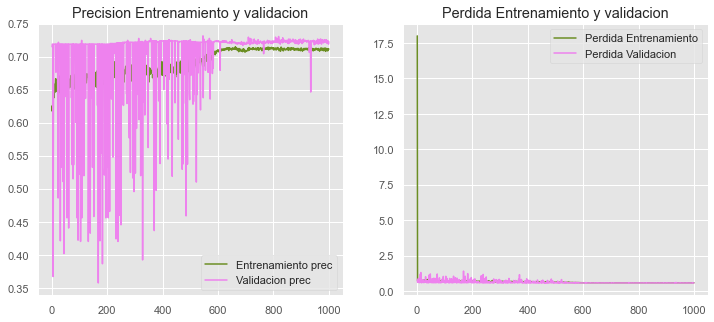

In [26]:
plot_history(history)


<h1>Comparación de la exactitud de ambos modelos</h1>
Comparamos la exactitud del modelo ComplementNB contra una red neuronal

In [27]:
print(f'# Exactitud ComplementNB: {exactitud_predefinido}%\n')
print(f'# Exactitud red neuronal: {exactitud_red}%\n')

# Exactitud ComplementNB: 97.89999999999999%

# Exactitud red neuronal: ('accuracy', 71.47002220153809)%



In [28]:
def mostar_resultado(df, number=2):
    for i in range(number):
        mensage = df['texto'].iloc[i]
        etiqueta = df["etiqueta"].iloc[i]
        msg_vector = vectorizador.transform([mensage])

        pred_etiqueta = model.predict(msg_vector)

        print(f"**Real: {etiqueta}, Prediccion: {pred_etiqueta[0]}**")

<h1>Observación</h1>
Mostramos lo predecido contra lo que hay en el documento(a modo de observación) y a continuación codigo para escribir daots correos spam

In [29]:
df_spam = df[(df['etiqueta'] == 'spam') & (df['clase'] == 1) ]
df_ham = df[(df['etiqueta'] == 'ham') & (df['clase'] == 0) ]
mostar_resultado(df_spam)
mostar_resultado(df_ham)


**Real: spam, Prediccion: spam**
**Real: spam, Prediccion: spam**
**Real: ham, Prediccion: ham**
**Real: ham, Prediccion: ham**


In [30]:
df_spam.to_csv('Dataset/leidos_spam.csv', sep='\t')
# Escribir documento(Por si queremos usar el csv para procesarlo para futuro analisis de datos)
